# **Customer Segmentation and Cohort Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **1: Categorizing Customers into Low, Medium, and High Price Purchasers**

In [15]:
# Load your data
data = pd.read_csv('e_commerce_no_missing_values.csv')
# Calculate total spending per customer
data['TotalSpent'] = data['Quantity'] * data['Price']
customer_spending = data.groupby('CustomerID')['TotalSpent'].sum().reset_index()

# Define quantiles for categorization (low, medium, high)
low_threshold = customer_spending['TotalSpent'].quantile(0.33)
high_threshold = customer_spending['TotalSpent'].quantile(0.67)

# Create a new column 'SpendingCategory' for classification
customer_spending['SpendingCategory'] = pd.cut(customer_spending['TotalSpent'],
                                               bins=[0, low_threshold, high_threshold, float('inf')],
                                               labels=['Low', 'Medium', 'High'])

# Merge this categorization back to the original data
data = data.merge(customer_spending[['CustomerID', 'SpendingCategory']], on='CustomerID', how='left')

In [16]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalSpent,SpendingCategory
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,Medium
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,Medium
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,Medium
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,Medium
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,Medium


### **2: Cohort Retention Rate for Three Classes**

In [32]:
# Convert 'InvoiceDate' to datetime format if not already done
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Create 'YearMonth' and 'CohortMonth' columns
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Create a period number representing months since the first purchase for each transaction
data['CohortIndex'] = (data['YearMonth'] - data['CohortMonth']).apply(lambda x: x.n)

In [35]:
# Function to calculate and visualize cohort retention rate for each spending category
def cohort_retention_rate(spending_category):
    # Filter data for the specific spending category
    data_filtered = data[data['SpendingCategory'] == spending_category]
    
    # Group by CohortMonth and CohortIndex to calculate unique customers
    cohort_data = data_filtered.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
    
    # Pivot table for cohort retention rates
    cohort_pivot = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')
    
    # Calculate the retention rate by dividing by the cohort size (first column)
    cohort_size = cohort_pivot.iloc[:, 0]
    cohort_retention = cohort_pivot.divide(cohort_size, axis=0) * 100
    
    # Visualize retention rates using a heatmap
    plt.figure(figsize=(25, 7))
    sns.heatmap(cohort_retention, annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Cohort Retention Rate for {spending_category} Purchasers')
    plt.xlabel('Number of Months After First Purchase')
    plt.ylabel('Cohort Month')
    plt.show()

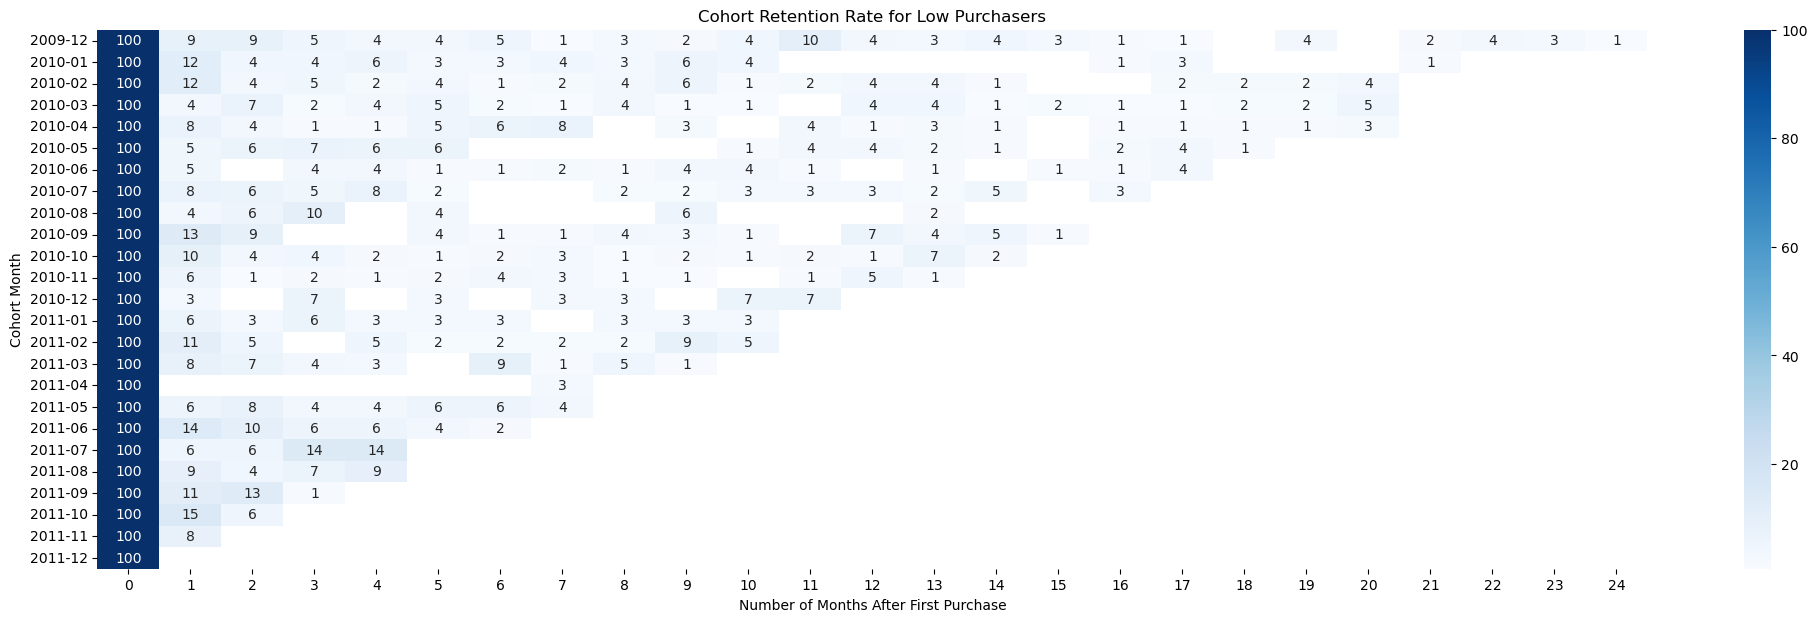

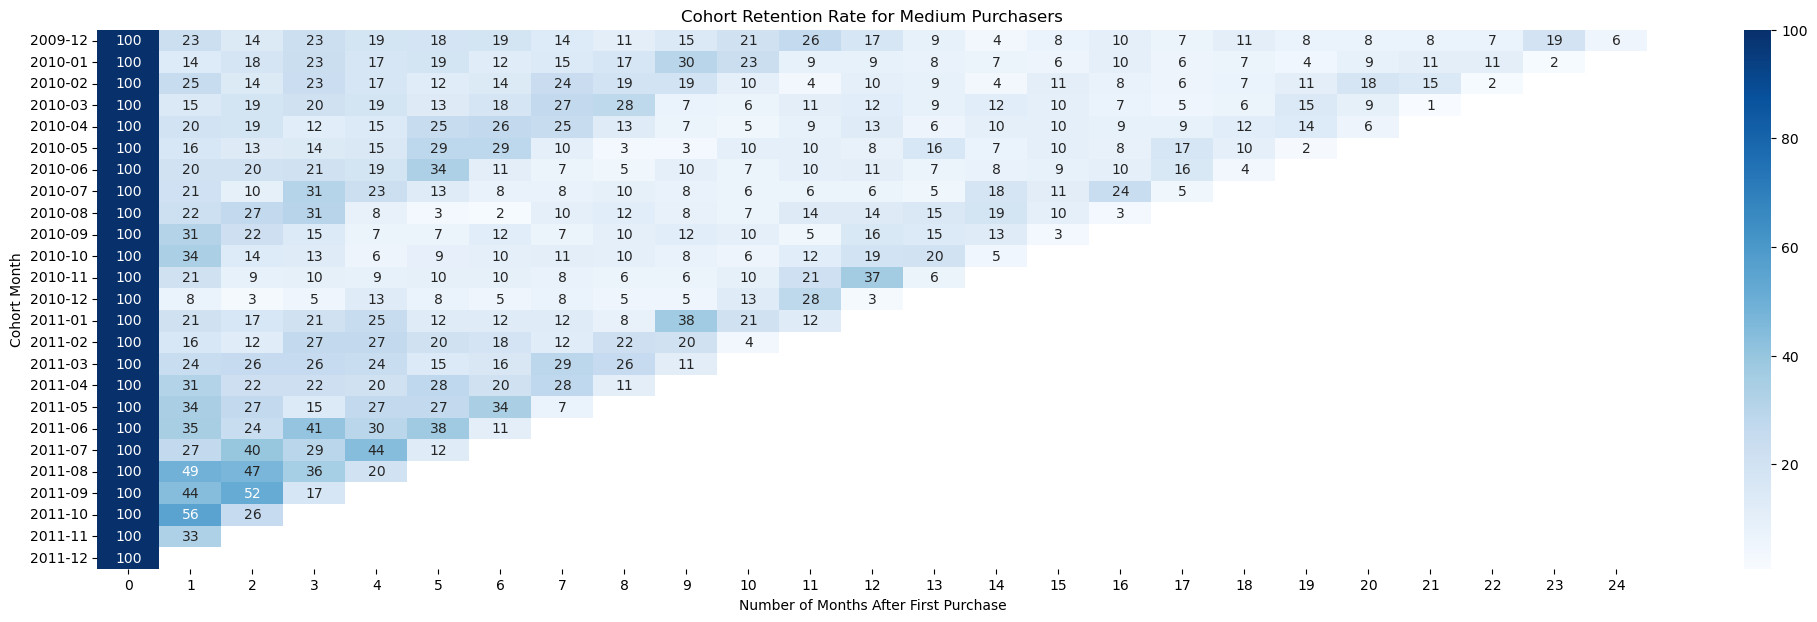

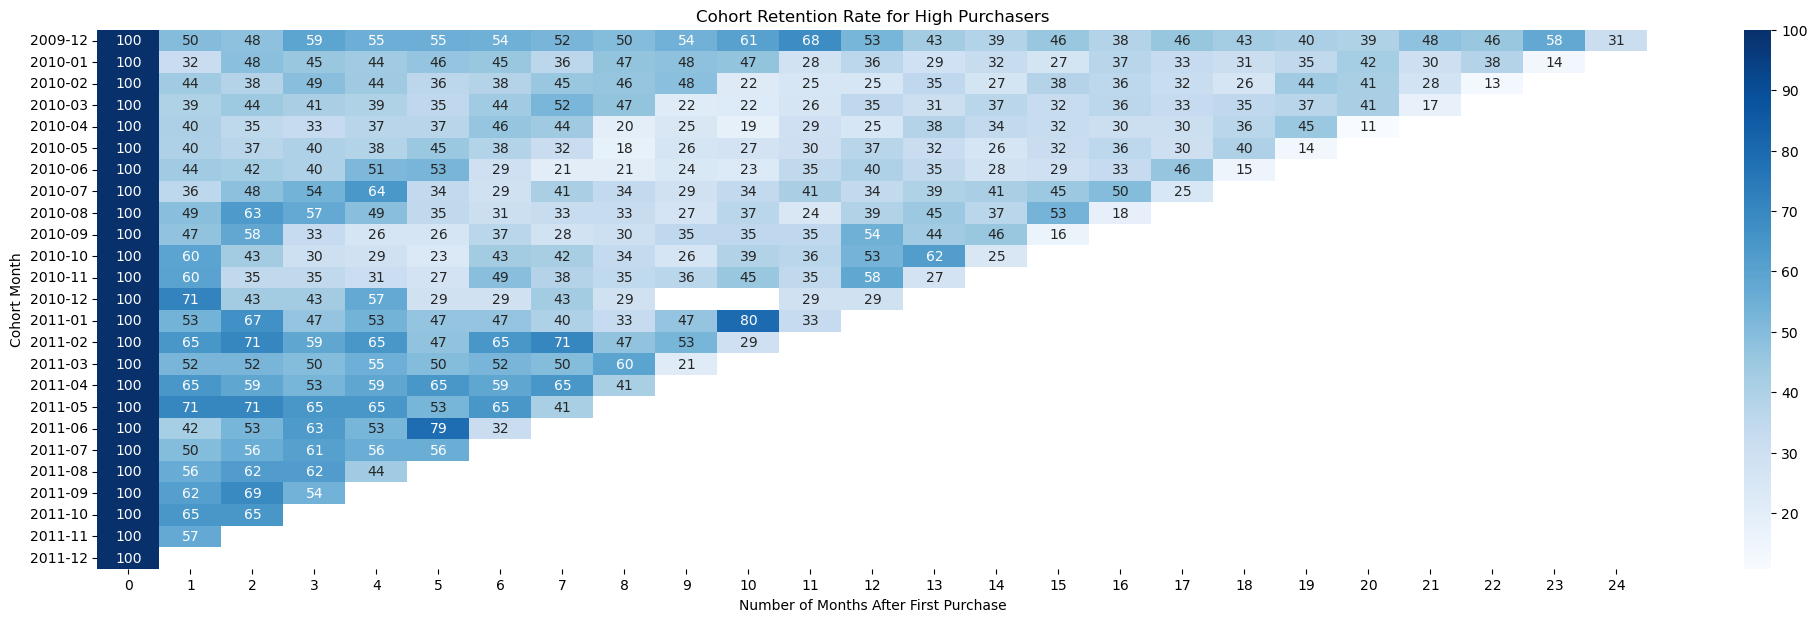

In [37]:
# Cohort retention rate for Low Purchasers
cohort_retention_rate('Low')

# Cohort retention rate for Medium Purchasers
cohort_retention_rate('Medium')

# Cohort retention rate for High Purchasers
cohort_retention_rate('High')

### **3: Cohort ARPU for Low, Medium, and High Classes**

In [39]:
# Function to calculate and visualize cohort ARPU for each spending category
def cohort_arpu(spending_category):
    # Filter data for the specific spending category
    data_filtered = data[data['SpendingCategory'] == spending_category]
    
    # Group by CohortMonth and CohortIndex to calculate total revenue
    cohort_revenue = data_filtered.groupby(['CohortMonth', 'CohortIndex'])['TotalSpent'].sum().reset_index()
    
    # Group by CohortMonth and CohortIndex to calculate unique customers
    cohort_customers = data_filtered.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
    
    # Pivot tables for cohort revenue and customers
    cohort_revenue_pivot = cohort_revenue.pivot_table(index='CohortMonth', columns='CohortIndex', values='TotalSpent')
    cohort_customers_pivot = cohort_customers.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')
    
    # Calculate ARPU by dividing total revenue by the number of customers
    cohort_arpu = cohort_revenue_pivot.divide(cohort_customers_pivot)
    
    # Visualize ARPU using a heatmap
    plt.figure(figsize=(25, 7))
    sns.heatmap(cohort_arpu, annot=True, fmt='.2f', cmap='Greens')
    plt.title(f'Cohort ARPU for {spending_category} Purchasers')
    plt.xlabel('Number of Months After First Purchase')
    plt.ylabel('Cohort Month')
    plt.show()

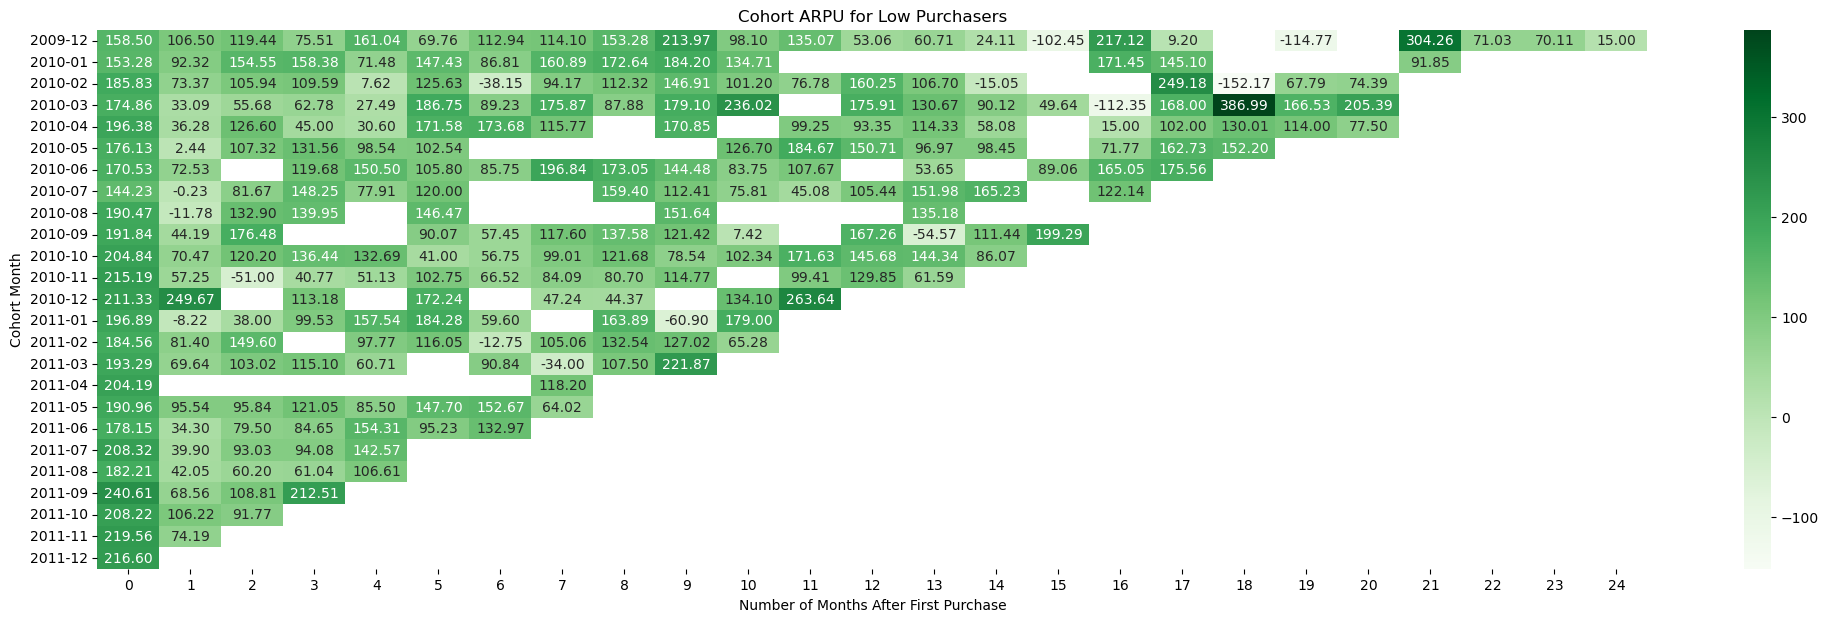

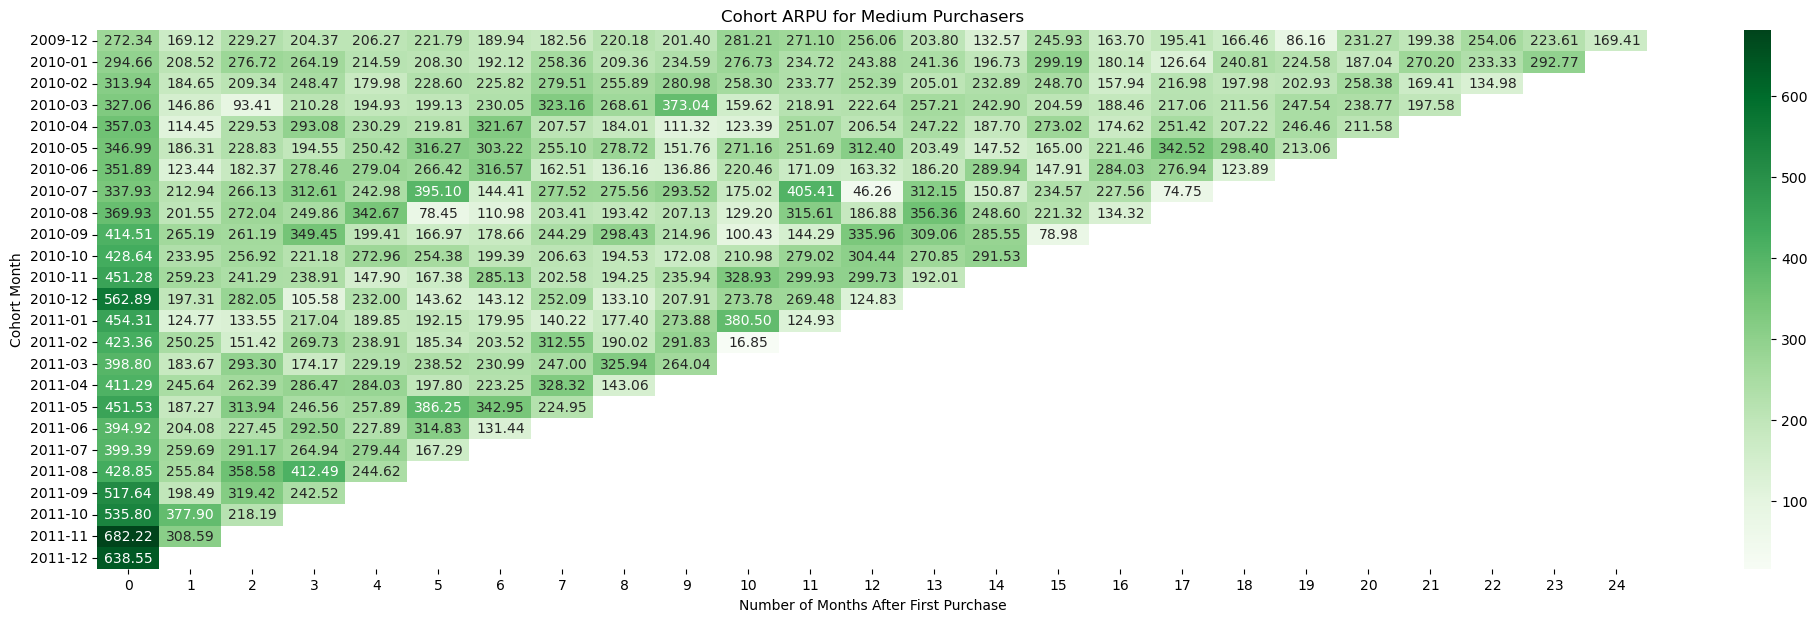

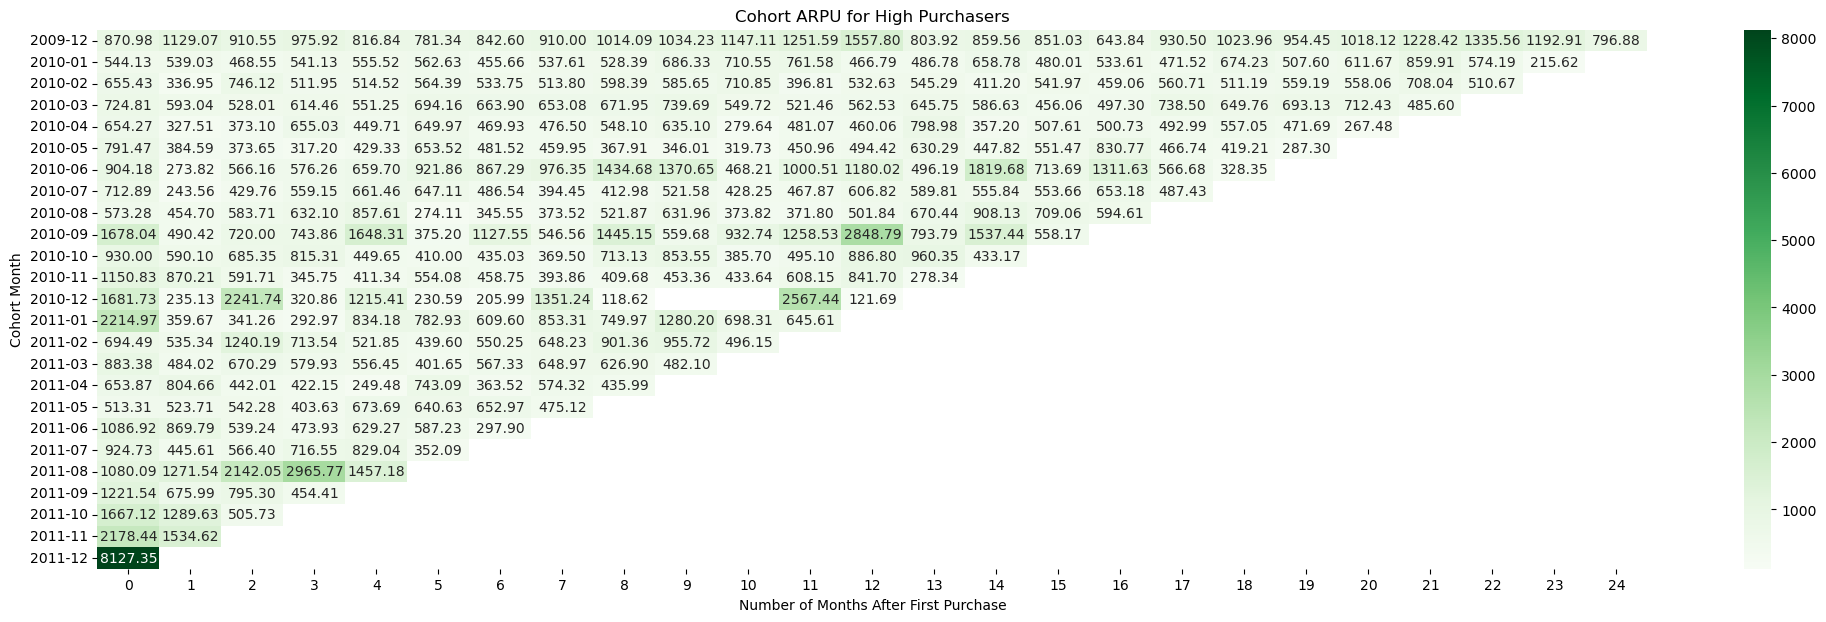

In [40]:
# Cohort ARPU for Low Purchasers
cohort_arpu('Low')

# Cohort ARPU for Medium Purchasers
cohort_arpu('Medium')

# Cohort ARPU for High Purchasers
cohort_arpu('High')

### **3: Cohort Churn Rate for Low, Medium, and High Classes**

In [52]:
# Determine churn status (True if no purchase within the last 6 months)
churn_period = pd.Timedelta(days=180)
end_date = data['InvoiceDate'].max()
data['LastPurchaseDate'] = data.groupby('CustomerID')['InvoiceDate'].transform('max')
data['Churned'] = (end_date - data['LastPurchaseDate'] > churn_period)

In [53]:
# Function to calculate and visualize cohort churn rate for each spending category
def cohort_churn_rate(spending_category):
    # Filter data for the specific spending category
    data_filtered = data[data['SpendingCategory'] == spending_category]
    
    # Group by CohortMonth and CohortIndex to calculate unique customers and churned customers
    cohort_customers = data_filtered.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
    cohort_churned = data_filtered.groupby(['CohortMonth', 'CohortIndex'])['Churned'].sum().reset_index()
    
    # Pivot tables for cohort churn and customers
    cohort_customers_pivot = cohort_customers.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')
    cohort_churned_pivot = cohort_churned.pivot_table(index='CohortMonth', columns='CohortIndex', values='Churned')
    
    # Calculate churn rate by dividing churned customers by total customers
    cohort_churn_rate = (cohort_churned_pivot / cohort_customers_pivot)
    
    # Visualize churn rate using a heatmap
    plt.figure(figsize=(25, 7))
    sns.heatmap(cohort_churn_rate, annot=True, fmt='.0f', cmap='Reds')
    plt.title(f'Cohort Churn Rate for {spending_category} Purchasers')
    plt.xlabel('Number of Months After First Purchase')
    plt.ylabel('Cohort Month')
    plt.show()

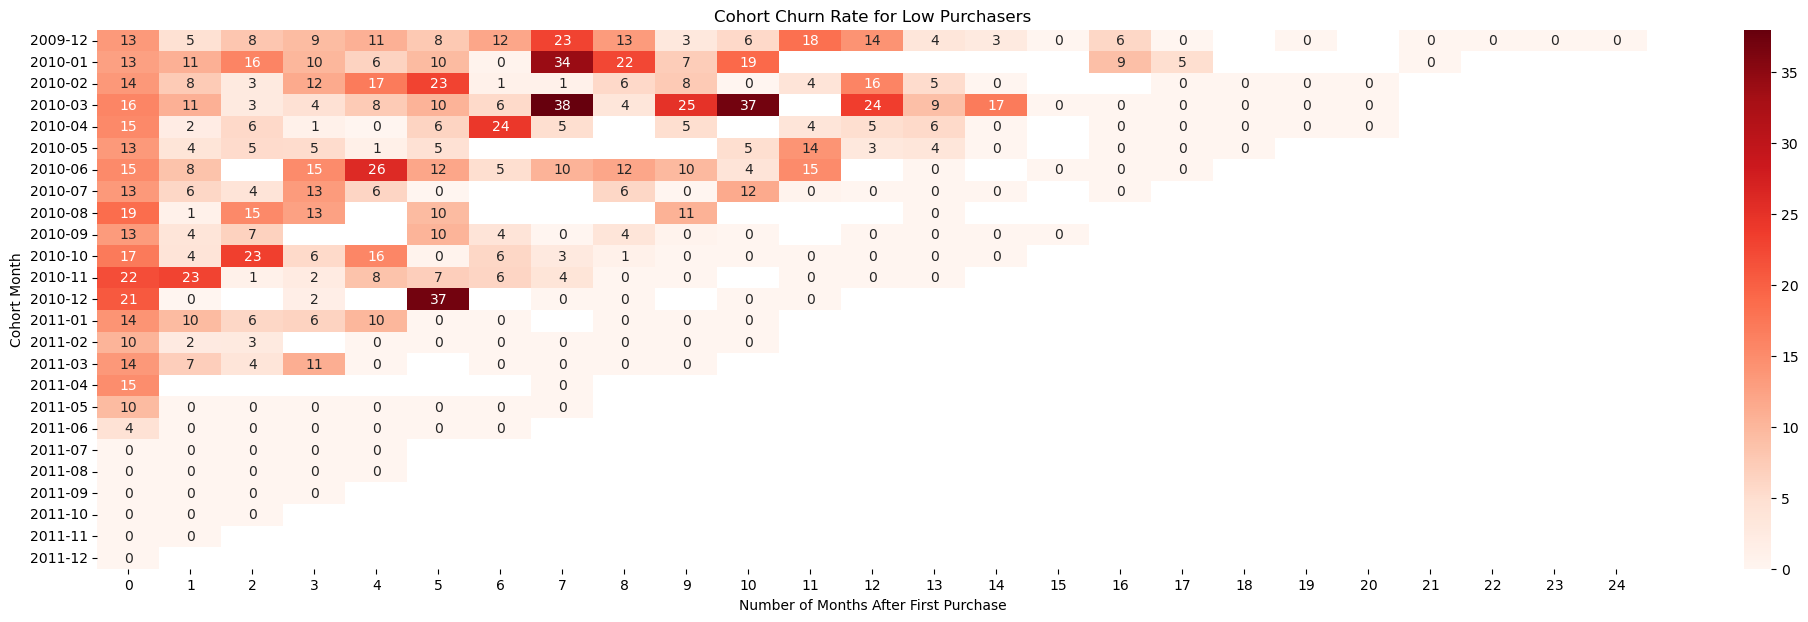

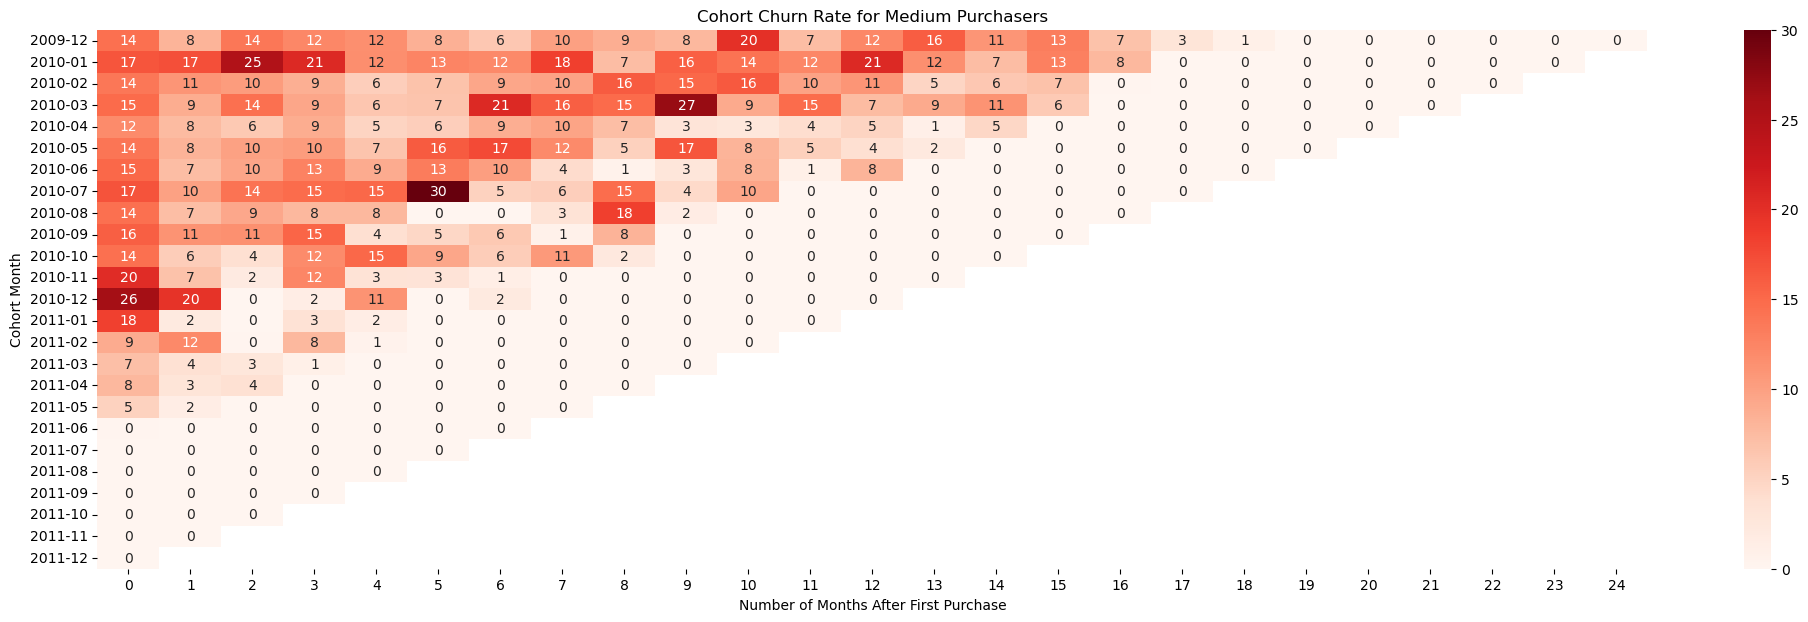

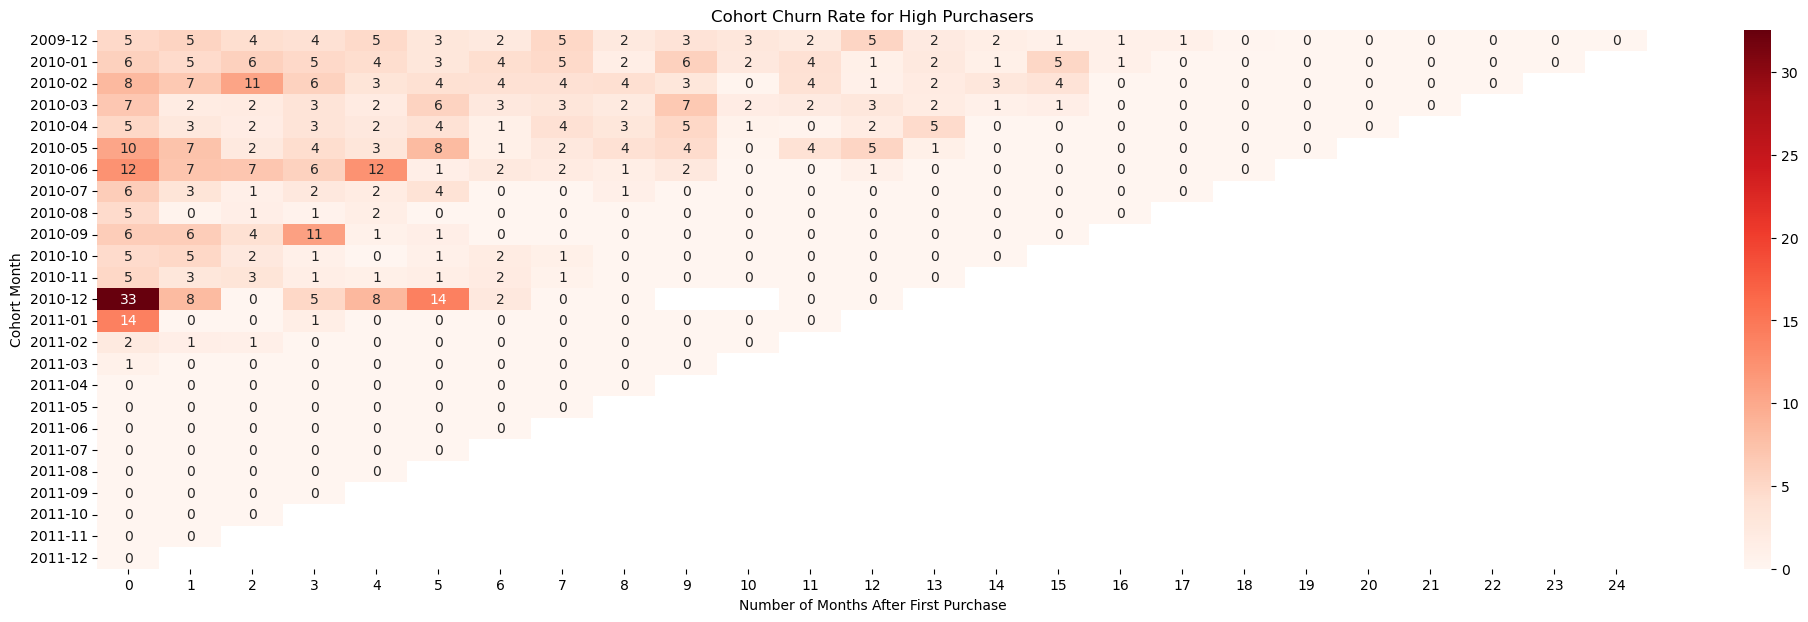

In [54]:
# Cohort Churn Rate for Low Purchasers
cohort_churn_rate('Low')

# Cohort Churn Rate for Medium Purchasers
cohort_churn_rate('Medium')

# Cohort Churn Rate for High Purchasers
cohort_churn_rate('High')